In [57]:
# Implementing Support Vector machines model on dataset for stock price prediction
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import yfinance as yf
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Importing the dataset
initial_df = pd.read_csv('SP500_stock_prices.csv', delimiter=',')
#initial_df = pd.read_csv('SP500_stock_prices.csv', delimiter=',')

# # Create a new column 'Price Movement'
# df['Daily Price Movement'] = np.where(df['Close'] > df['Close'].shift(1), 1, 0)

initial_df.head()

,Date,Ticker,Open,Low,High,Close,Volume,Sector
0,2016-01-04,MMM,148.050003,145.399994,148.320007,146.820007,3277200,Industrials
1,2016-01-05,MMM,146.820007,145.610001,147.500000,147.460007,2688100,Industrials
2,2016-01-06,MMM,145.589996,143.419998,145.759995,144.490005,2997100,Industrials
3,2016-01-07,MMM,142.520004,140.630005,143.130005,140.970001,3553500,Industrials
4,2016-01-08,MMM,141.360001,140.220001,142.500000,140.490005,2664000,Industrials


In [58]:
# Make date column the index
initial_df = initial_df.set_index('Date')

In [59]:
# only display year, month and day in index
initial_df.index = pd.to_datetime(initial_df.index).date
data = initial_df
data
# make return column
data['Return'] = data['Close'].pct_change()

In [4]:
print(data['Sector'].unique())
# assign each different Sector string its own number
data['Sector'] = data['Sector'].map({'Consumer Discretionary': 0, 'Consumer Staples': 1, 'Energy': 2, 'Financials': 3, 'Health Care': 4, 'Industrials': 5, 'Information Technology': 6, 'Materials': 7, 'Real Estate': 8, 'Communication Services': 9, 'Utilities': 10})

['Industrials' 'Health Care' 'Information Technology'
 'Communication Services' 'Consumer Staples' 'Consumer Discretionary'
 'Utilities' 'Financials' 'Materials' 'Real Estate' 'Energy']


In [5]:
# make a new column for whether or not the price has increased or decreased from the previous 62 days
# 1 = increased, 0 = decreased, doing so by comparing openprice of today with openprice of 62 days ago
data['63-day Price Movement'] = np.where(data['Open'] > data['Open'].shift(-63), 1, 0)

In [6]:
# Make the tickers to categoricals, but keep the original order of the tickers
data['Ticker'] = pd.Categorical(data['Ticker'], categories=data['Ticker'].unique(), ordered=True)
data['Ticker'] = data['Ticker'].cat.codes
# # make target column
# data['Target'] = data['62-day Price Movement'].shift(-62)
# #data['Price Movement 62 Days'] = data['Price Movement'].shift(62)
# data.dropna(inplace=True)
# data

In [7]:
# select only the ticker index
indiviual_datas = []

for ticker in data['Ticker'].unique():
    #data_ticker = data.xs(0, level=1).copy()
    data_ticker = data[data['Ticker'] == ticker].copy()
    # make target column
    data_ticker['Target'] = data_ticker['63-day Price Movement'].shift(-63)
    #data['Price Movement 62 Days'] = data['Price Movement'].shift(62)
    data_ticker.dropna(inplace=True)
    data_ticker

    indiviual_datas.append(data_ticker)

data_all_tickers = pd.concat(indiviual_datas)

data_all_tickers

,Ticker,Open,Low,High,Close,Volume,Sector,Return,63-day Price Movement,Target
2016-01-05,0,146.820007,145.610001,147.500000,147.460007,2688100,5,0.004359,0,0.0
2016-01-06,0,145.589996,143.419998,145.759995,144.490005,2997100,5,-0.020141,0,0.0
2016-01-07,0,142.520004,140.630005,143.130005,140.970001,3553500,5,-0.024362,0,0.0
2016-01-08,0,141.360001,140.220001,142.500000,140.490005,2664000,5,-0.003405,0,0.0
2016-01-11,0,140.970001,139.410004,141.429993,140.460007,2775500,5,-0.000214,0,0.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,497,132.210007,131.289993,133.080002,132.919998,442500,4,0.004155,1,0.0
2019-12-26,497,133.190002,132.320007,133.190002,133.029999,929400,4,0.000828,1,0.0
2019-12-27,497,133.399994,132.380005,133.479996,133.250000,1296100,4,0.001654,1,0.0
2019-12-30,497,133.570007,131.809998,133.660004,132.210007,942000,4,-0.007805,1,0.0


In [477]:
# check PE-Ratio for inf values
# find Tickers with inf values for PE-Ratio
data_all_tickers[data_all_tickers['PE-Ratio'] == np.inf]['Ticker'].unique()
# removing all rows with the tickers that have infinity values in their PE-Ratios
for wrong_ticker in data_all_tickers[data_all_tickers['PE-Ratio'] == np.inf]['Ticker'].unique():
    data_all_tickers = data_all_tickers[data_all_tickers['Ticker'] != wrong_ticker]

In [135]:
# Splitting the dataset into the Training set and Test set according to date
# Define the specific date to split the DataFrame
# Create an offset of 62 Business days
#bd = pd.tseries.offsets.BusinessDay(n = 62)
#split_date = pd.to_datetime('2019-09-30') - bd

# set a start date for the training set to be 62 days after the first date in the dataset
#start_date = pd.to_datetime('2016-01-04') + bd

# small test dataset creation:

bd = pd.tseries.offsets.BusinessDay(n = 63)
split_date = pd.to_datetime('2019-11-30') - bd
start_date = pd.to_datetime('2019-01-04') + bd


# Split the DataFrame into training and test sets based on the specific date
# for train we want all the data from the start date to the split date, this ensures that we have 62 days of data for each stock
# for test we want all the data from the split date to the end of the dataset
train = data_all_tickers.loc[(start_date < data_all_tickers.index) & (data_all_tickers.index < split_date)]
train_log = train
train_log['Low'] = np.log(train_log['Low'])
train_log['High'] = np.log(train_log['High'])
train_log['Open'] = np.log(train_log['Open'])
test = data_all_tickers.loc[data_all_tickers.index >= split_date]
test_log = test
test_log['Low'] = np.log(test_log['Low'])
test_log['High'] = np.log(test_log['High'])
test_log['Open'] = np.log(test_log['Open'])
X_train = train_log[['Ticker','Open', 'Low', 'High', 'Volume', 'Sector']]
y_train = train['Target']
X_test = test_log[['Ticker', 'Open', 'Low', 'High', 'Volume', 'Sector']]
y_test = test['Target']


C:\Users\nicol\AppData\Local\Temp\ipykernel_12256\1478331573.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_log['Low'] = np.log(train_log['Low'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_12256\1478331573.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_log['High'] = np.log(train_log['High'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_12256\1478331573.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [9]:
# print any nan values in the test set
print(test.isnull().sum())

Ticker                   0
Open                     0
Low                      0
High                     0
Close                    0
Volume                   0
Sector                   0
Return                   0
63-day Price Movement    0
Target                   0
dtype: int64


In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM model
model = SVC(kernel='rbf', probability=True) # linear, rbf, poly, sigmoid
model.fit(X_train, y_train)

# Get the probabilities for each class
y_pred_proba = model.predict_proba(X_test)

In [115]:
# predicted probabilities for the positive class
y_scores = model.predict_proba(X_test)[:, 1]

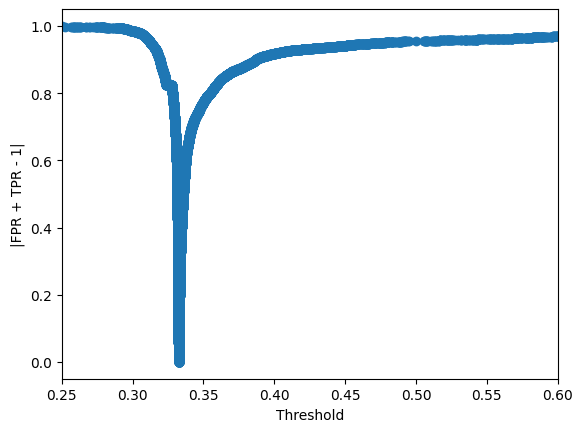

In [116]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
# roc_auc = auc(fpr, tpr)

fpr, tpr, thresholds = roc_curve(y_test,y_scores,drop_intermediate=False)
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
# let x-axis go from 0.25 to 0.6
plt.xlim([0.25,0.6])
plt.ylabel("|FPR + TPR - 1|")
plt.show()


In [185]:
from sklearn.metrics import f1_score
# Create a list of possible thresholds and f1 scores
thresholds = np.arange(0.332, 0.5, 0.001)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_scores > threshold).astype(int)
    score = f1_score(y_test, y_pred)
    f1_scores.append(score)

# Find the threshold that gave the highest f1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
optimal_score = np.max(f1_scores)

print(f"Optimal threshold is: {optimal_threshold}")
print(f"Highest F1 score at optimal threshold is: {optimal_score}")


Optimal threshold is: 0.332
Highest F1 score at optimal threshold is: 0.678954954954955


In [186]:
# Set custom threshold
threshold = optimal_threshold

# Make a prediction using the trained SVM model with the custom threshold applied
y_pred = (y_pred_proba[:,1] > threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



Accuracy: 0.5671881072677808


In [187]:
print(sum(y_pred))

26633


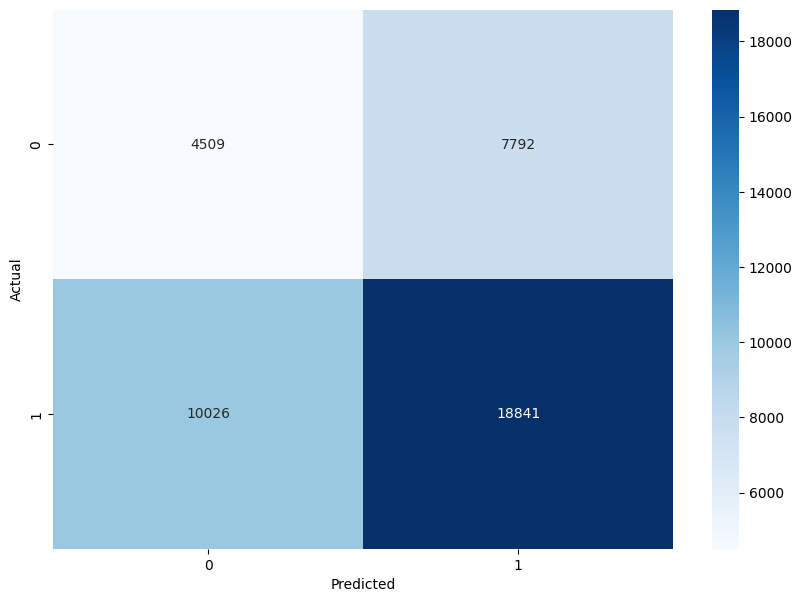

In [188]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap()
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [49]:

# 5-fold cross-validation:
all_data = data_all_tickers.loc[(start_date < data_all_tickers.index)]
X = all_data[['Ticker','Open', 'Low', 'High', 'Volume', 'Sector']]
y = all_data['Target']

# Perform 5-fold cross-validation
scores = cross_val_score(model, scaler.transform(X), y, cv=5)

print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


NameError: name 'cross_val_score' is not defined

In [293]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Standardize the input features
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM model
model = SVC(kernel = 'rbf', probability=True)
# model = SVC(kernel='rbf', probability=True, class_weight='balanced')
model.fit(X_train, y_train)

# Make a prediction using the trained SVM model
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# # Perform 5-fold cross-validation
# scores = cross_val_score(model, scaler.transform(X), y, cv=5)

# print(f"Cross-validation scores: {scores}")
# print(f"Average cross-validation score: {scores.mean()}")


Accuracy: 0.4459045860862806


In [29]:
# save model to file
# import pickle
# pickle.dump(model, open('svm_modelwithoutPE.sav', 'wb'))

In [50]:
ticker_name_df = pd.read_csv('SP500_stock_prices.csv', delimiter=',')
# Make date column the index
ticker_name_df = ticker_name_df.set_index('Date')
# only display year, month and day in index
ticker_name_df.index = pd.to_datetime(ticker_name_df.index).date
# only keep the Ticker
ticker_name_df = ticker_name_df[['Ticker']]
# drop duplicates
ticker_name_df = ticker_name_df.drop_duplicates()
# remove the index
ticker_name_df = ticker_name_df.reset_index(drop=True)
ticker_name_df

,Ticker
0,MMM
1,AOS
2,ABT
3,ABBV
4,ACN
...,...
493,YUM
494,ZBRA
495,ZBH
496,ZION


In [136]:
test['Ticker'] = test['Ticker'].astype('category')
#  make y_pred and y_pred_proba a column in the test dataset
test['Prediction'] = y_pred
test['Prediction Probability (0)'] = y_pred_proba[:,0]
test['Prediction Probability (1)'] = y_pred_proba[:,1]
# only keep columns for ticker, target, and prediction
test = test[['Ticker', 'Target', 'Prediction', 'Prediction Probability (1)', 'Prediction Probability (0)', 'Return']]
# make the ticker column a name again


C:\Users\nicol\AppData\Local\Temp\ipykernel_12256\244758554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Ticker'] = test['Ticker'].astype('category')
C:\Users\nicol\AppData\Local\Temp\ipykernel_12256\244758554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = y_pred
C:\Users\nicol\AppData\Local\Temp\ipykernel_12256\244758554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

__Portfolio Performance, if bought on each testing day and kept for respective 62 trade days.__

In [145]:
import cvxpy as cp
import pandas as pd

def calculate_optimal_weights(test, date, k, threshold):
    # only keep the rows of a specific date
    # make a date be of type datetime
    date = pd.to_datetime(date)
    
    # make a new dataframe where return is the index and each column is a ticker
    return_df = test.pivot(columns='Ticker', values='Return')
    # remove stocks that have nan values in the return column
    return_df = return_df.dropna(axis=1)
    # for each ticker only keep the row of the input date
    test = test.groupby('Ticker').apply(lambda x: x.loc[x.index == date])
    test['Ticker'] = test['Ticker'].cat.remove_unused_categories()
    
    # ensure that the tickers in test are the same as the tickers in return_df
    test = test[test['Ticker'].isin(return_df.columns)]

    return_deviation = return_df.iloc[0:62]
    
    # Calculate the covariance matrix
    cov_matrix = return_deviation.cov()
    # Force the covariance matrix to be symmetric
    cov_matrix = (cov_matrix + cov_matrix.T) / 2
    
    # Number of stocks
    n = len(test['Ticker'])
    # Weights for each stock in the portfolio
    w = cp.Variable(n)
    # Objective is to minimize portfolio variance
    risk = cp.quad_form(w, cov_matrix)
    
    # Parameter for the cardinality constraint
    #k = 50
    # Cardinality constraint with penalty in the objective
    objective = cp.Minimize(risk - k * cp.sum(w))
    # objective = cp.Minimize(risk)
    
    # Constraints:
    # - weights must sum to 1
    # - only consider stocks where the SVM prediction is 1 (price will increase)
    # - expected portfolio return must be at least a certain value (e.g., 0.01)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        #w <= 0.1,
        #w[df_date["Prediction"] == 0] == 0,
        w[test["Prediction"] == 0 ] == 0,
        
        #w.T @ df_date["Prediction Probability (1)"] >= 0.05
        w.T @ test["Prediction Probability (1)"] >= threshold
    ]
 
    
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)

    problem.solve()

    # Get the optimal weights
    optimal_weights = w.value
    if optimal_weights is None:
        optimal_weights = np.zeros(n)
    # Create a dataframe with the optimal weights
    optimal_weights_df = pd.DataFrame(optimal_weights, index=test["Ticker"])
    # add the ticker names to the dataframe
    optimal_weights_df = optimal_weights_df.join(ticker_name_df)
    # remove the index
    optimal_weights_df = optimal_weights_df.reset_index(drop=True)
    # make the ticker the index
    optimal_weights_df = optimal_weights_df.set_index('Ticker')
    # make the column name weights
    optimal_weights_df.columns = ['Weights']

    # Sort the dataframe by the optimal weights
    optimal_weights_df = optimal_weights_df.sort_values(by=['Weights'], ascending=False)

    # Only keep the top 10 stocks and their weights, but exclude the most weighted stock
    #optimal_weights_df = optimal_weights_df.iloc[1:11]
    optimal_weights_df = optimal_weights_df.head(10)
    # normalize the weights so that they sum to 1
    optimal_weights_df['Weights'] = optimal_weights_df['Weights'] / optimal_weights_df['Weights'].sum()
    return round(optimal_weights_df,3)


In [53]:

import pandas as pd

def calculate_return(ticker, df, start_date):
    # Convert string dates to datetime
    start_date = pd.to_datetime(start_date)
    # Calculate the end date as start date + 62 trading days
    end_date = start_date + pd.tseries.offsets.BDay(63)
    # remove nan values from df
    df = df.dropna(axis=1)
    
    # Filter the dataframe for the given ticker
    df_ticker = df[df['Ticker'] == ticker]
    # Filter data between start and end dates
    mask = (df_ticker.index >= start_date) & (df_ticker.index <= end_date)
    df_ticker = df_ticker.loc[mask]
    
    # Get the opening price at the start and end dates
    start_price = df_ticker['Open'].iloc[0]
    end_price = df_ticker['Open'].iloc[-1]

    # Calculate the return
    return_percent = ((end_price - start_price) / start_price) * 100

    return round(return_percent,2)


In [146]:
def calculate_average_return(test, initial_df, k, prob_threshold):
    # Initialize returns list
    returns_list = []

    # For each date in the test set
    for date in test.index.unique():
        # Calculate the optimal weights for the portfolio
        optimal_weights_df = calculate_optimal_weights(test, date, k, prob_threshold)

        # Calculate the return of the portfolio
        return_list = []
        for ticker in optimal_weights_df.index:
            if optimal_weights_df.loc[ticker]['Weights'] > 0:
                # Calculate the return of the stock
                return_list.append(calculate_return(ticker, initial_df, date))

        # Calculate the return of the portfolio
        portfolio_return = 0
        for i in range(len(return_list)):
            portfolio_return += return_list[i] * optimal_weights_df.iloc[i]['Weights']

        # Append the return to the list
        returns_list.append(round(portfolio_return,1))
    
    # Calculate and return the average portfolio return
    return np.mean(returns_list)


In [190]:
# Define the values of k and prob_threshold to test
# let k go from 0 to 100 in steps of 5
k_values = np.arange(0,5,1)
# let prob_threshold go from 0.1 to 0.45 in steps of 0.05
prob_threshold_values = np.arange(0.20, 0.45, 0.05)

# Initialize a list to store the results
results = []

# For each combination of k and prob_threshold
for k in k_values:
    for prob_threshold in prob_threshold_values:
        # Calculate the average return
        avg_return = calculate_average_return(test, initial_df, k, prob_threshold)
        # Store the results
        results.append((0, prob_threshold, avg_return))
        print(f"k={k}, prob_threshold={prob_threshold}, avg_return={avg_return}")

# Sort the results by average return
results.sort(key=lambda x: x[2], reverse=True)

# Print the optimal parameters
print(f"Optimal parameters: k={results[0][0]}, prob_threshold={results[0][1]}, avg_return={results[0][2]}")


KeyboardInterrupt: 

In [152]:
k = results[0][0]
prob_threshold = results[0][1]

In [155]:
# for each date in the test set calculate the return of the portfolio
# empty list to store the returns
returns_list = []
# for each date in the test set
for date in test.index.unique():
    # calculate the optimal weights for the portfolio
    optimal_weights_df = calculate_optimal_weights(test, date, k, prob_threshold)
    #print(optimal_weights_df)
    # calculate the return of the portfolio
    # for the top 10 weighted stocks in the portfolio calculate their return
    # empty list to store the returns
    return_list = []
    # for each stock in the portfolio
    for ticker in optimal_weights_df.index:
        if optimal_weights_df.loc[ticker]['Weights'] > 0:
            # calculate the return of the stock
            return_list.append(calculate_return(ticker, initial_df, date))
    # Calculate the return of the portfolio
    portfolio_return = 0
    for i in range(len(return_list)):
        portfolio_return += return_list[i] * optimal_weights_df.iloc[i]['Weights']
    # append the return to the list
    returns_list.append(round(portfolio_return,1))

In [174]:
# Make a dataframe with the returns and dates
returns_df = pd.DataFrame(returns_list, index=test.index.unique())
# make the column name returns
returns_df.columns = ['SVM Portfolio 3-month Returns (%)']
returns_df

,SVM Portfolio 3-month Returns (%)
2019-09-18,0.2
2019-09-19,1.7
2019-09-20,-0.6
2019-09-23,1.5
2019-09-24,-0.2
...,...
2019-12-09,2.1
2019-12-10,6.2
2019-12-11,-0.7
2019-12-12,-3.2


In [175]:
# average return
print('Average return:', round(returns_df.mean()[0],2))

Average return: 4.54


In [173]:
# show the 10 days with the most return
returns_df.sort_values(by=['SVM Portfolio 3-month Returns (%)'], ascending=False).head(10)


,SVM Portfolio 3-month Returns (%)
2019-11-26,13.1
2019-11-22,11.9
2019-11-25,11.7
2019-11-19,10.8
2019-11-27,10.8
2019-11-21,10.3
2019-11-18,10.0
2019-11-13,8.8
2019-11-15,8.8
2019-11-14,8.8


SP500 return in the same period

In [159]:
import yfinance as yf
from pandas_datareader import data as pdr
# This line is needed to fix a problem with pandas_datareader
yf.pdr_override()

start_date = '2019-09-04'
end_date = '2020-04-02'
# 
# Get data from Yahoo Finance
sp500 = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
# we are only interested in the open price
sp500 = sp500['Open']
# Transform it into a dataframe
sp500_returns = pd.DataFrame(sp500)
# Make 'S&P 500 Index Price' the column header
sp500_returns = sp500_returns.rename(columns={'Open': 'S&P 500 Index Price'})
# Calculate the 3 month return for each day
sp500_returns['S&P 500 - 3 Month Return (%)'] = sp500_returns['S&P 500 Index Price'].pct_change(periods=63).shift(-63)
# calculating all 3-month return values by 100 to obtain percent
sp500_returns['S&P 500 - 3 Month Return (%)'] = sp500_returns['S&P 500 - 3 Month Return (%)'] * 100
sp500_returns.round(2)
# remove the S&P 500 Index Price column
sp500_returns = sp500_returns.drop(columns=['S&P 500 Index Price'])
# removing all rows with NaN values (The last 62 days, since they don't have data for 3 months into the future)
sp500_returns = sp500_returns.dropna()
sp500_returns

[*********************100%***********************]  1 of 1 completed


,S&P 500 - 3 Month Return (%)
Date,
2019-09-04,5.564388
2019-09-05,4.826721
2019-09-06,4.659883
2019-09-09,4.891873
2019-09-10,5.750573
...,...
2019-12-24,-22.451438
2019-12-26,-20.802239
2019-12-27,-21.194988


In [160]:
# add the returns of random monkey model as a new column
random_monkey_returns = pd.read_csv('random_monkey_portfolio_returns.csv', index_col=0)

In [161]:
# make random monkey index as datetime
random_monkey_returns.index = pd.to_datetime(random_monkey_returns.index)


In [162]:
# Combine the returns of the portfolio and the S&P 500
combined_returns = pd.concat([returns_df, sp500_returns], axis='columns', join='inner')

#combined_returns['Random Monkey Portfolio 62-day Returns (%)'] = random_monkey_returns['Random Monkey - 3 Month Return (%)']
# make a column that shows the difference between the portfolio returns and the S&P 500 returns
#combined_returns['Difference (%)'] = combined_returns['Portfolio 62-day Returns (%)'] - combined_returns['S&P 500 - 3 Month Return (%)']
combined_returns.round(1)

,SVM Portfolio 3-month Returns (%),S&P 500 - 3 Month Return (%)
2019-09-04,-2.1,5.6
2019-09-05,-2.8,4.8
2019-09-06,-3.2,4.7
2019-09-09,-2.1,4.9
2019-09-10,-0.7,5.8
...,...,...
2019-12-24,-24.6,-22.5
2019-12-26,-26.8,-20.8
2019-12-27,-24.3,-21.2
2019-12-30,-21.2,-19.3


In [163]:
# add a new column that shows the Random Monkey returns
combined_returns['Random Monkey 63-day Returns (%)'] = random_monkey_returns['Random Monkey - 3 Month Return (%)'].copy()
round(combined_returns,1)

,SVM Portfolio 3-month Returns (%),S&P 500 - 3 Month Return (%),Random Monkey 63-day Returns (%)
2019-09-04,-2.1,5.6,5.9
2019-09-05,-2.8,4.8,1.5
2019-09-06,-3.2,4.7,3.9
2019-09-09,-2.1,4.9,-0.8
2019-09-10,-0.7,5.8,4.2
...,...,...,...
2019-12-24,-24.6,-22.5,-14.3
2019-12-26,-26.8,-20.8,-25.4
2019-12-27,-24.3,-21.2,-27.4
2019-12-30,-21.2,-19.3,-40.3


In [164]:
# average return of each column
average_return = combined_returns.mean()
average_return


SVM Portfolio 3-month Returns (%)    0.763855
S&P 500 - 3 Month Return (%)         0.979898
Random Monkey 63-day Returns (%)     0.637349
dtype: float64

In [165]:
# standard deviation of each column
standard_deviation = combined_returns.std()
standard_deviation

SVM Portfolio 3-month Returns (%)     9.016821
S&P 500 - 3 Month Return (%)         12.145304
Random Monkey 63-day Returns (%)     14.115600
dtype: float64

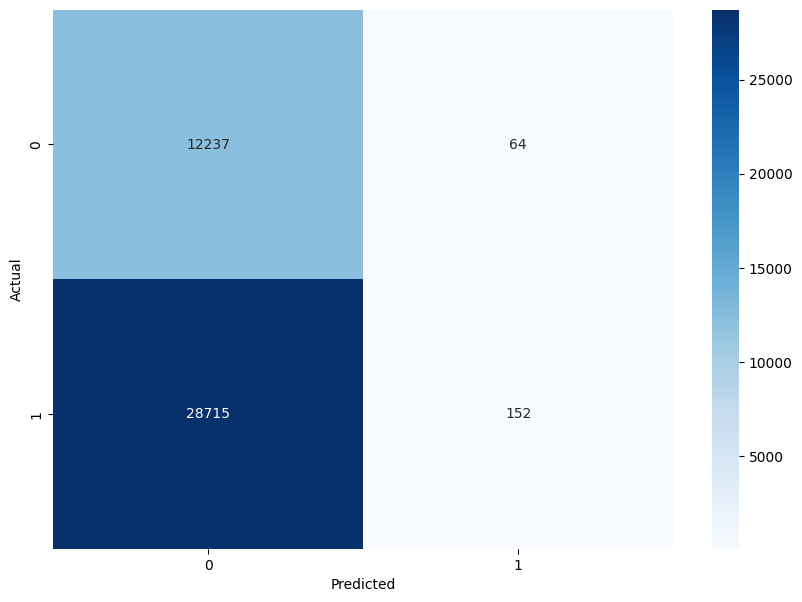

In [466]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap()
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [467]:
from scipy import stats
# calculate whether there is a significant difference between the portfolio returns and the S&P 500 returns
# calculate the t-statistic
t_statistic = (average_return['SVM Portfolio 3-month Returns (%)'] - average_return['S&P 500 - 3 Month Return (%)']) / standard_deviation['SVM Portfolio 3-month Returns (%)']
# calculate the p-value
p_value = stats.t.sf(np.abs(t_statistic), len(combined_returns)-1)*2
# print the results
print('t-statistic: ', round(t_statistic,2))
print('p-value for SVM Portfolio and S&P500 returns: ', round(p_value,2))


t-statistic:  0.02
p-value for SVM Portfolio and S&P500 returns:  0.98


In [276]:
# calculate whether there is a significant difference between the portfolio returns and the S&P 500 returns
# calculate the t-statistic
t_statistic = (average_return['Portfolio 63-day Returns (%)'] - average_return['Random Monkey 63-day Returns (%)']) / standard_deviation['Portfolio 63-day Returns (%)']
# calculate the p-value
p_value = stats.t.sf(np.abs(t_statistic), len(combined_returns)-1)*2
# print the results
print('t-statistic: ', round(t_statistic,2))
print('p-value for SVM Portfolio and Random Monkey returns: ', round(p_value,2))

t-statistic:  0.12
p-value for SVM Portfolio and Random Monkey returns:  0.9


__Backup-results in case it fails__:

In [ ]:
# Make a dataframe with the returns and dates
returns_df = pd.DataFrame(returns_list, index=test.index.unique())
# make the column name returns
returns_df.columns = ['Portfolio 62-day Returns (%)']
returns_df

,Portfolio 62-day Returns (%)
2019-09-05,8.0
2019-09-06,6.1
2019-09-09,5.3
2019-09-10,5.4
2019-09-11,4.2
...,...
2019-12-26,-54.0
2019-12-27,-50.8
2019-12-30,-21.6
2019-12-31,-21.1
